In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, ConfusionMatrixDisplay
)

plt.rcParams["figure.figsize"] = (8,5)


In [64]:
# Load dataset
df = pd.read_csv("employee_churn_dataset.csv")

# Normalize Work-Life Balance if needed
if df["Work-Life Balance"].dtype == object:
    wlb_map = {"Poor": 1, "Average": 2, "Good": 3, "Excellent": 4}
    df["Work-Life Balance"] = df["Work-Life Balance"].map(wlb_map)

print("Shape:", df.shape)
print("\nChurn distribution:")
print(df["Churn"].value_counts(normalize=True).round(3))
df.head()


Shape: (10000, 22)

Churn distribution:
Churn
0    0.797
1    0.203
Name: proportion, dtype: float64


,Employee ID,Age,Gender,Education Level,Marital Status,Tenure,Job Role,Department,Salary,Work Location,...,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Work-Life Balance,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Churn
0,E00001,50,Male,Bachelor's,Married,5,Analyst,Marketing,93422,Remote,...,35,0,16,0.03,1,155,14,15,7.9,0
1,E00002,36,Male,Bachelor's,Married,4,Manager,Sales,44589,On-site,...,1,0,12,0.39,2,162,2,8,5.2,0
2,E00003,29,Male,Bachelor's,Married,3,Sales,IT,56768,Hybrid,...,41,0,2,0.62,1,243,6,21,6.3,0
3,E00004,42,Male,Bachelor's,Single,12,Analyst,Sales,79009,On-site,...,33,0,8,0.73,3,291,11,25,7.4,0
4,E00005,40,Other,Bachelor's,Married,1,Sales,HR,81982,On-site,...,30,0,13,0.52,2,272,3,1,4.1,0


In [65]:
target = "Churn"
drop_cols = ["Employee ID"]

X = df.drop(columns=[target] + drop_cols, errors="ignore")
y = df[target].astype(int)

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Categorical:", cat_cols)
print("Numeric:", num_cols)


Categorical: ['Gender', 'Education Level', 'Marital Status', 'Job Role', 'Department', 'Work Location']
Numeric: ['Age', 'Tenure', 'Salary', 'Performance Rating', 'Projects Completed', 'Training Hours', 'Promotions', 'Overtime Hours', 'Satisfaction Level', 'Work-Life Balance', 'Average Monthly Hours Worked', 'Absenteeism', 'Distance from Home', 'Manager Feedback Score']


In [ ]:
numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
])
log_reg = Pipeline([("prep", preprocess), ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
rf = Pipeline([("prep", preprocess), ("clf", RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced_subsample"))])
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

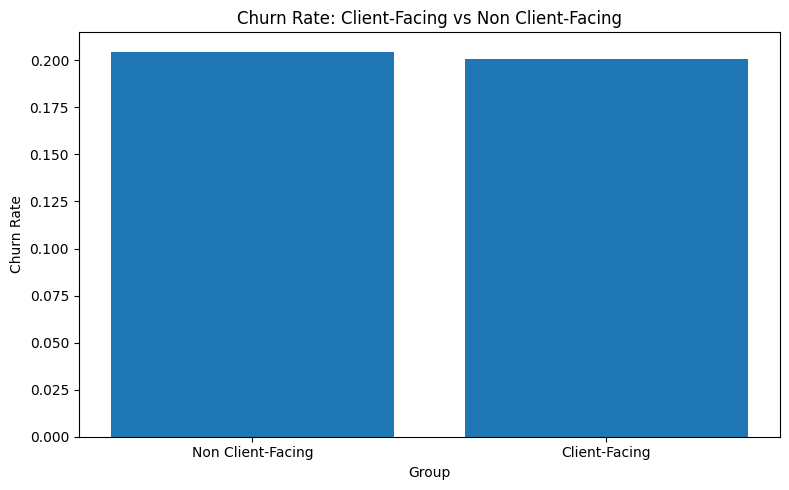

In [ ]:
def tune_threshold(y_true, y_proba, min_precision=0.25):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.0)
    mask = precisions >= min_precision
    if mask.sum() == 0:
        idx = np.argmax(recalls)
    else:
        idx = np.where(mask)[0][np.argmax(recalls[mask])]
    return thresholds[idx], precisions[idx], recalls[idx]

for name, model in [("LogReg", log_reg), ("RandomForest", rf)]:
    y_proba = model.predict_proba(X_test)[:,1]
    thr, p, r = tune_threshold(y_test, y_proba, min_precision=0.25)
    print(f"{name}: threshold={thr:.3f}, precision={p:.2f}, recall={r:.2f}, AUC={roc_auc_score(y_test, y_proba):.2f}")


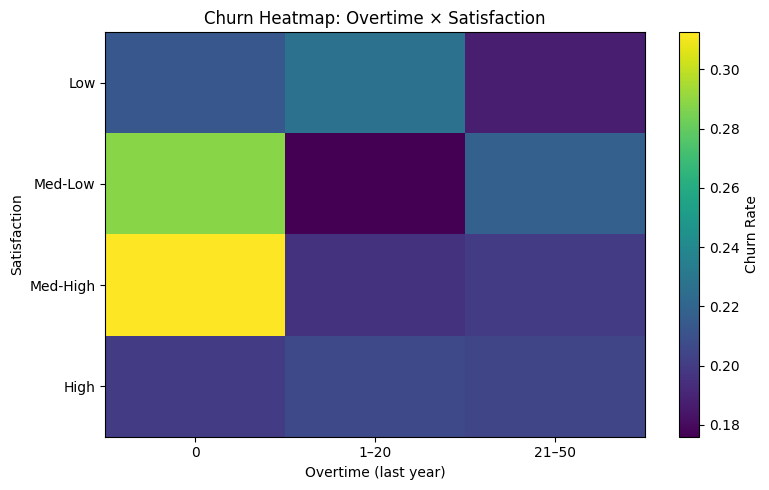

In [ ]:
# Use Random Forest as example
y_proba = rf.predict_proba(X_test)[:, 1]
best_thr, p, r = tune_threshold(y_test, y_proba, min_precision=0.25)

plt.figure(figsize=(8,6))
plt.hist(y_proba[y_test==0], bins=20, alpha=0.6, label="Stayed (0)")
plt.hist(y_proba[y_test==1], bins=20, alpha=0.6, label="Left (1)")
plt.axvline(best_thr, color="red", linestyle="--", label=f"Tuned Threshold = {best_thr:.2f}")
plt.title("Predicted Probability of Attrition — Classified by Model")
plt.xlabel("Predicted Probability of Leaving")
plt.ylabel("Number of Employees")
plt.legend()
plt.tight_layout()
plt.show()


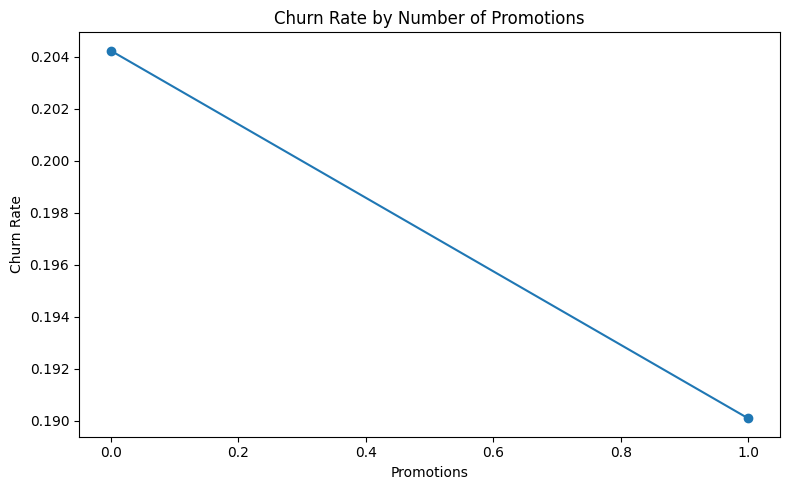

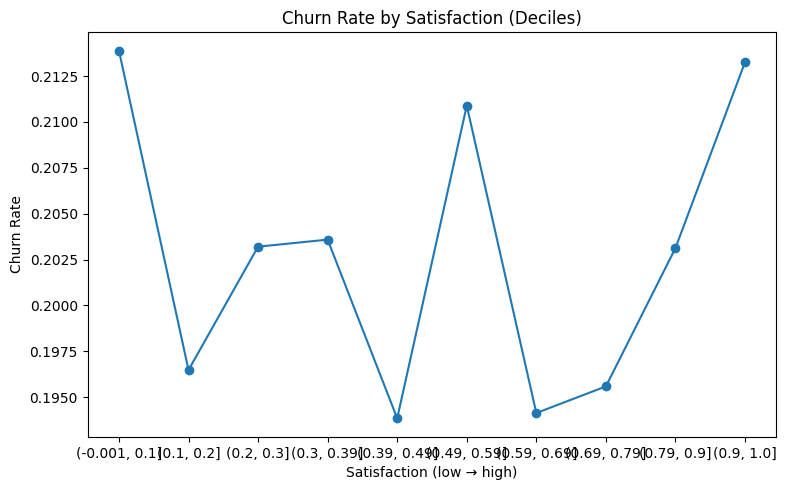

In [ ]:
y_pred = (y_proba >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed","Left"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix at Tuned Threshold")
plt.show()

print(classification_report(y_test, y_pred, digits=3))


In [ ]:
for name, model in [("LogReg", log_reg), ("RandomForest", rf)]:
    y_proba = model.predict_proba(X_test)[:,1]
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve — {name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f"Precision–Recall Curve — {name}")
    plt.show()


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


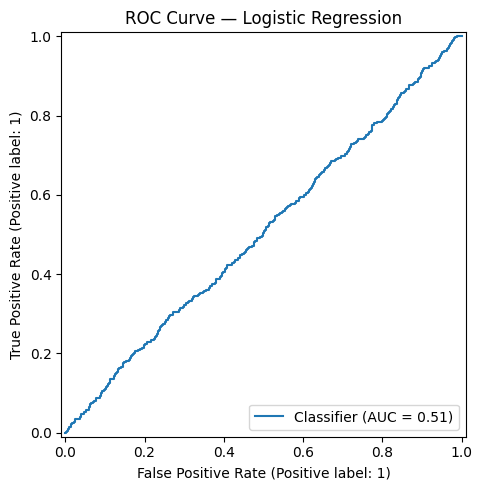

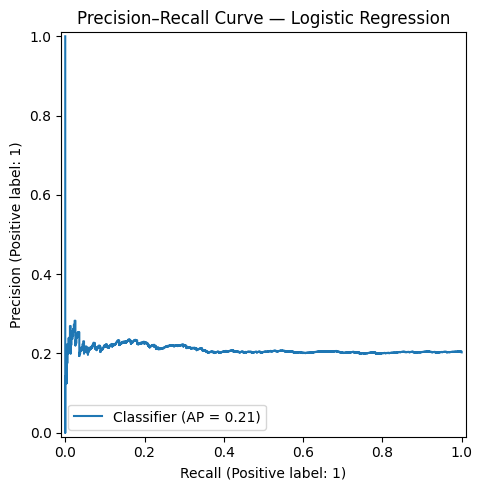

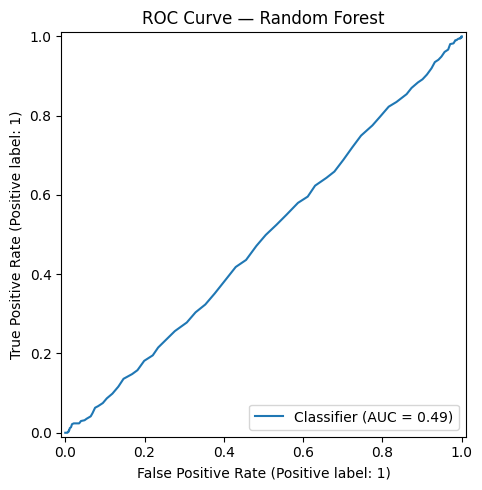

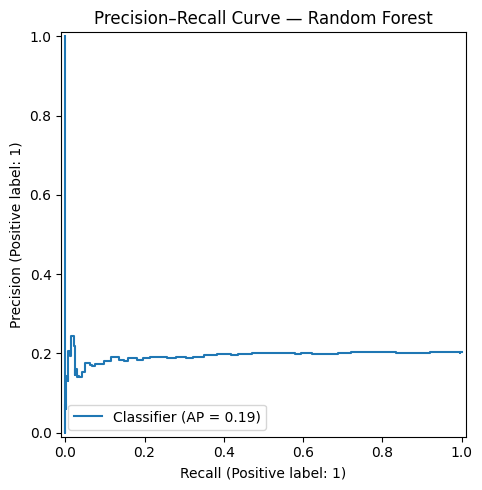

In [ ]:
# Cell 9 — ROC and PR curves
for name, model in [("Logistic Regression", log_reg), ("Random Forest", rf)]:
    y_proba = model.predict_proba(X_test)[:,1]
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve — {name}")
    plt.tight_layout()
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f"Precision–Recall Curve — {name}")
    plt.tight_layout()
    plt.show()


In [ ]:
# Cell 10 — Threshold tuning to favor recall (subject to precision floor)
def tune_threshold(y_true, y_proba, min_precision=0.25):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.0)  # align
    mask = precisions >= min_precision
    if mask.sum() == 0:
        idx = np.argmax(recalls)
    else:
        idx_local = np.argmax(recalls[mask])
        idx = np.where(mask)[0][idx_local]
    return float(thresholds[idx]), float(precisions[idx]), float(recalls[idx])

for name, model in [("Logistic Regression", log_reg), ("Random Forest", rf)]:
    y_proba = model.predict_proba(X_test)[:,1]
    thr, p, r = tune_threshold(y_test, y_proba, min_precision=0.25)
    y_pred = (y_proba >= thr).astype(int)

    print(f"\n{name} tuned threshold ≈ {thr:.3f} (precision≥0.25)")
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))



Logistic Regression tuned threshold ≈ 0.554 (precision≥0.25)
              precision    recall  f1-score   support

           0      0.799     0.973     0.877      1993
           1      0.250     0.036     0.062       507

    accuracy                          0.783      2500
   macro avg      0.524     0.504     0.470      2500
weighted avg      0.687     0.783     0.712      2500

Confusion Matrix:
 [[1939   54]
 [ 489   18]]
ROC-AUC: 0.5071487880164403

Random Forest tuned threshold ≈ 1.000 (precision≥0.25)
              precision    recall  f1-score   support

           0      0.797     1.000     0.887      1993
           1      0.000     0.000     0.000       507

    accuracy                          0.797      2500
   macro avg      0.399     0.500     0.444      2500
weighted avg      0.636     0.797     0.707      2500

Confusion Matrix:
 [[1993    0]
 [ 507    0]]
ROC-AUC: 0.4882018029572934


C:\Users\akash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\akash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_clas

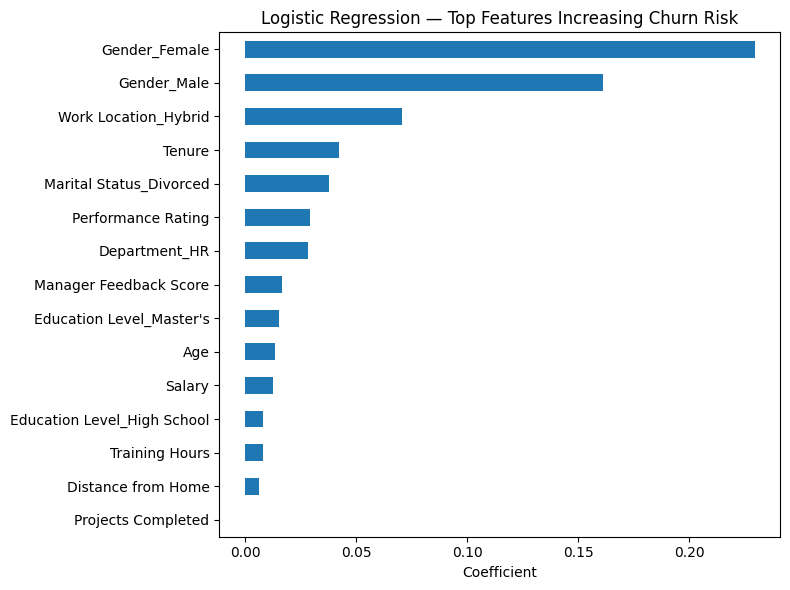

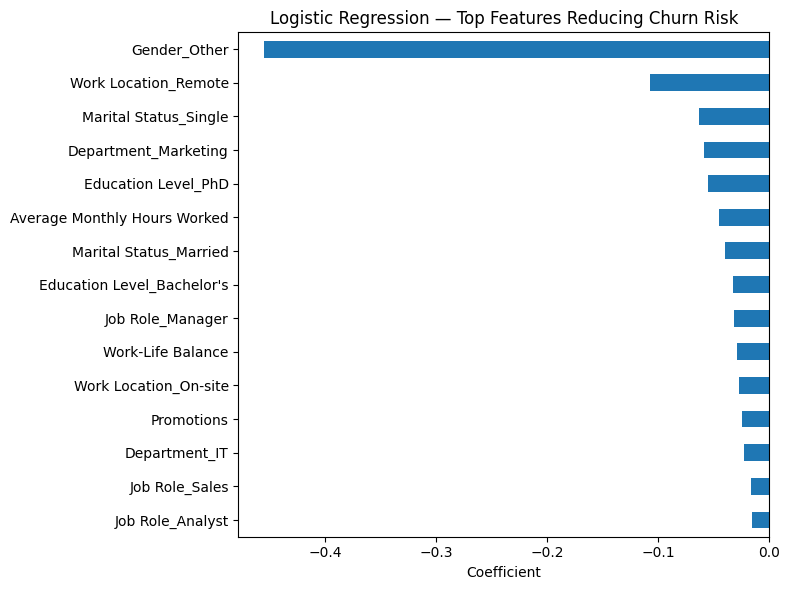

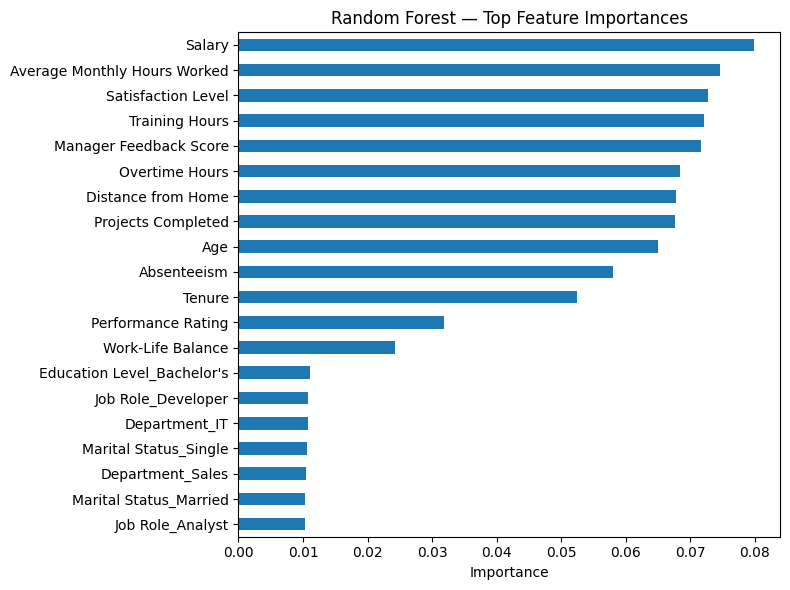

In [ ]:
# Cell 11 — Feature importance (LogReg coefficients + RF importances)
def get_feature_names(column_transformer):
    out = []
    for nm, trans, cols in column_transformer.transformers_:
        if nm == "remainder":
            continue
        if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
            out.extend(trans.named_steps["onehot"].get_feature_names_out(cols))
        elif hasattr(trans, "get_feature_names_out"):
            out.extend(trans.get_feature_names_out(cols))
        else:
            out.extend(cols)
    return out

feature_names = get_feature_names(preprocess)

# Logistic regression coefficients
lr_clf = log_reg.named_steps["clf"]
lr_imp = pd.Series(lr_clf.coef_[0], index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
lr_imp.head(15).sort_values().plot(kind="barh")
plt.title("Logistic Regression — Top Features Increasing Churn Risk")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
lr_imp.tail(15).plot(kind="barh")
plt.title("Logistic Regression — Top Features Reducing Churn Risk")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

# Random forest importances
rf_clf = rf.named_steps["clf"]
rf_imp = pd.Series(rf_clf.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
rf_imp.head(20).sort_values().plot(kind="barh")
plt.title("Random Forest — Top Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


C:\Users\akash\AppData\Local\Temp\ipykernel_15216\385724698.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perf_tbl = work.groupby("PerfQuartile")["Churn"].mean().reindex(["Q1 (Lowest)","Q2","Q3","Q4 (Top)"])


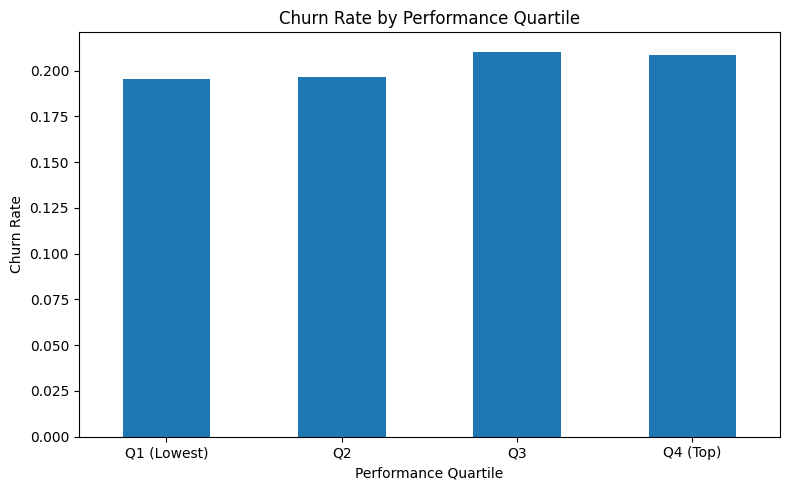

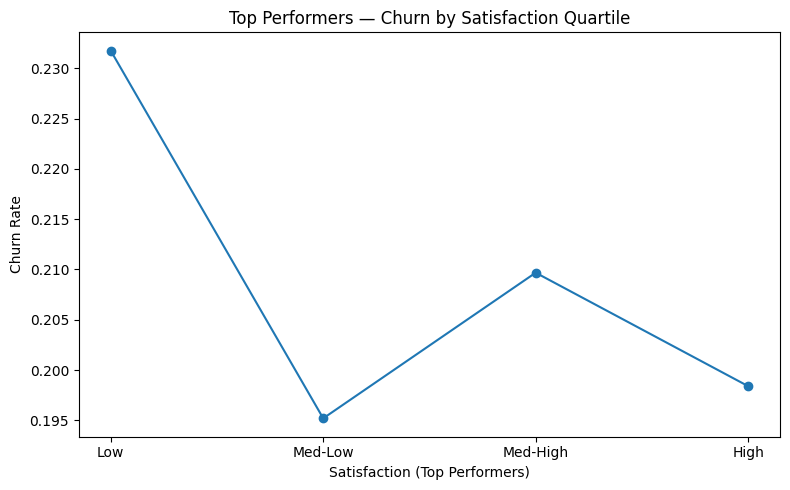

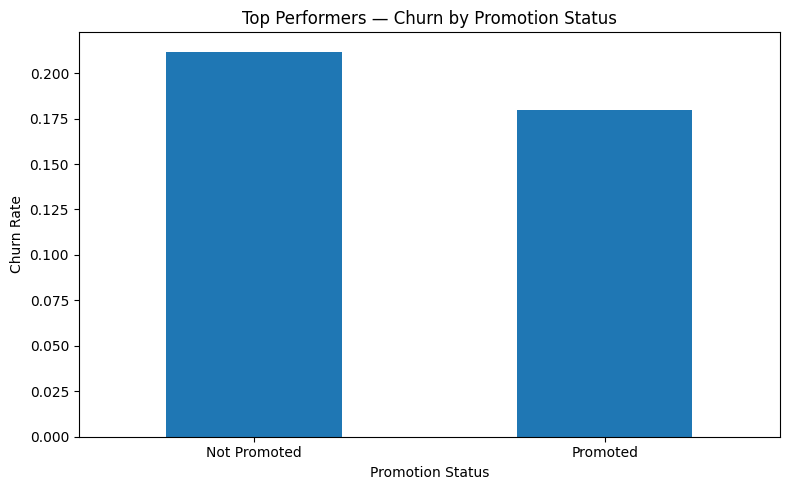

In [ ]:
# Cell 12 — Decision-support: identify high performers at risk
# Performance index from z-scores (rating, feedback, projects)
work = df.copy()
for col in ["Performance Rating", "Manager Feedback Score", "Projects Completed"]:
    work[f"z_{col}"] = (work[col] - work[col].mean()) / work[col].std(ddof=0)
work["PerfIndex"] = work[[f"z_{c}" for c in
                          ["Performance Rating","Manager Feedback Score","Projects Completed"]]].mean(axis=1)
work["PerfQuartile"] = pd.qcut(work["PerfIndex"].rank(method="first"), q=4,
                               labels=["Q1 (Lowest)","Q2","Q3","Q4 (Top)"])

# Churn rate by performance quartile
perf_tbl = work.groupby("PerfQuartile")["Churn"].mean().reindex(["Q1 (Lowest)","Q2","Q3","Q4 (Top)"])
perf_tbl.plot(kind="bar")
plt.title("Churn Rate by Performance Quartile")
plt.xlabel("Performance Quartile")
plt.ylabel("Churn Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Within top performers, satisfaction effect
top_perf = work[work["PerfQuartile"] == "Q4 (Top)"].copy()
sat_top = rate_by_bucket(top_perf["Satisfaction Level"], top_perf["Churn"], q=4,
                         labels=["Low","Med-Low","Med-High","High"])
plt.plot(sat_top["bin"].astype(str), sat_top["churn_rate"], marker="o")
plt.title("Top Performers — Churn by Satisfaction Quartile")
plt.xlabel("Satisfaction (Top Performers)")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()

# Within top performers, promotion status effect
top_perf["Promoted"] = np.where(top_perf["Promotions"] > 0, "Promoted", "Not Promoted")
prom_tbl = top_perf.groupby("Promoted")["Churn"].mean().reindex(["Not Promoted","Promoted"])
prom_tbl.plot(kind="bar")
plt.title("Top Performers — Churn by Promotion Status")
plt.xlabel("Promotion Status")
plt.ylabel("Churn Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


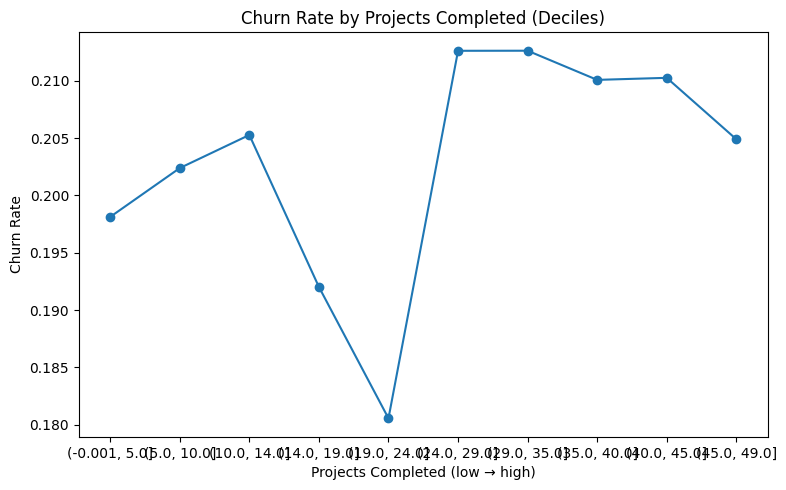

In [ ]:
# Cell 13 — Decision-support: project load risk (delivery continuity)
proj_tbl = rate_by_bucket(df["Projects Completed"], df["Churn"], q=10)
plt.plot(proj_tbl["bin"].astype(str), proj_tbl["churn_rate"], marker="o")
plt.title("Churn Rate by Projects Completed (Deciles)")
plt.xlabel("Projects Completed (low → high)")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()


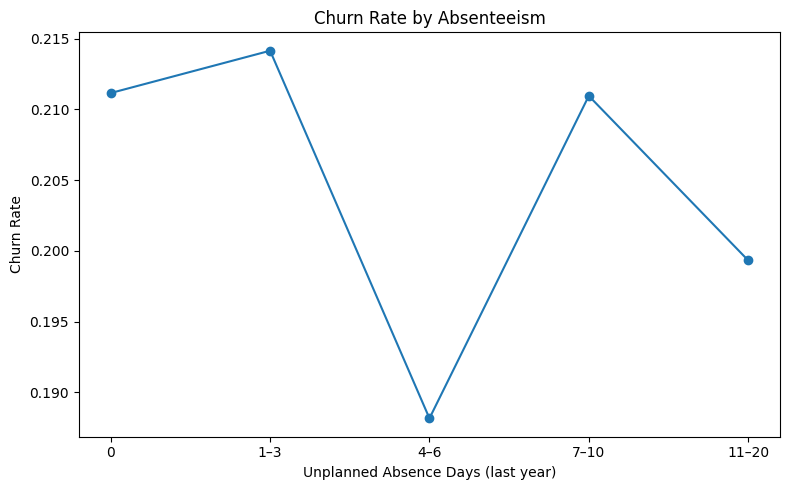

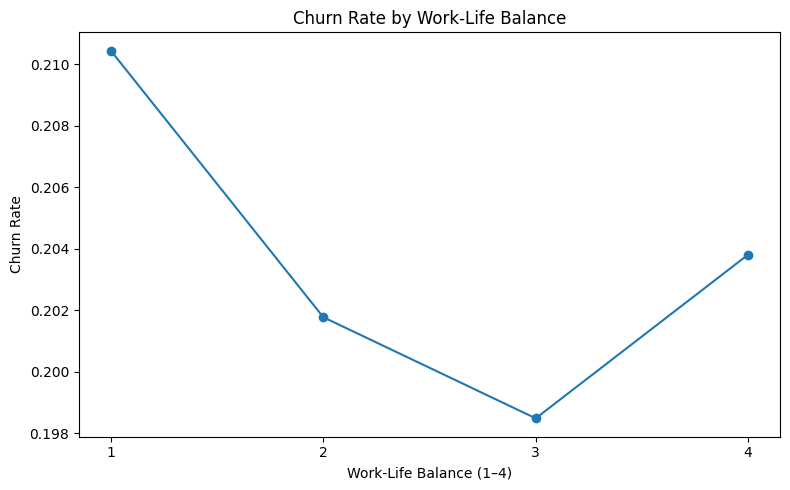

In [ ]:
# Cell 14 — Decision-support: absenteeism and work-life balance
abs_bins = [-0.1, 0, 3, 6, 10, 20, 50]
abs_labels = ["0","1–3","4–6","7–10","11–20","20+"]
abs_tbl = rate_by_bucket(df["Absenteeism"], df["Churn"], bins=abs_bins, labels=abs_labels)
plt.plot(abs_tbl["bin"].astype(str), abs_tbl["churn_rate"], marker="o")
plt.title("Churn Rate by Absenteeism")
plt.xlabel("Unplanned Absence Days (last year)")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()

wlb_tbl = df.groupby("Work-Life Balance")["Churn"].mean().reset_index()
plt.plot(wlb_tbl["Work-Life Balance"].astype(str), wlb_tbl["Churn"], marker="o")
plt.title("Churn Rate by Work-Life Balance")
plt.xlabel("Work-Life Balance (1–4)")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()


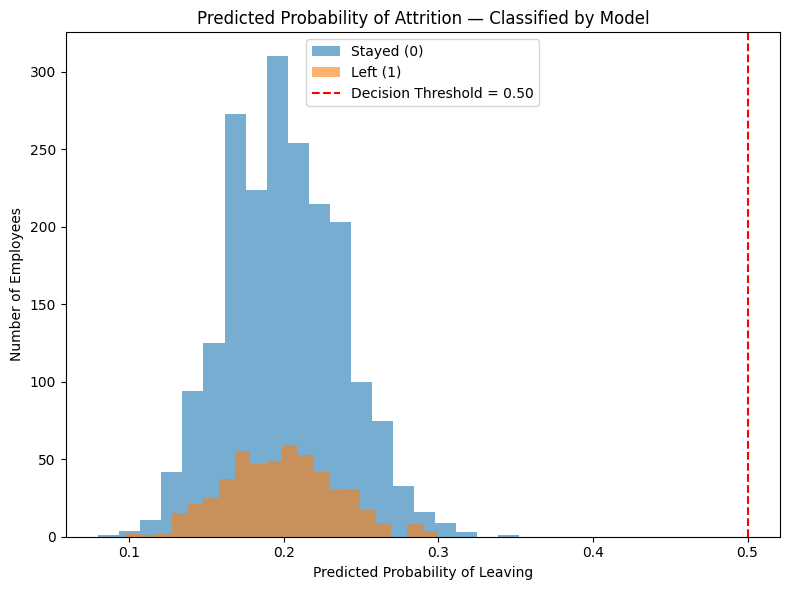

In [ ]:
# Predict churn probabilities using Random Forest (can swap in log_reg)
y_proba = rf.predict_proba(X_test)[:, 1]

# Choose a threshold (default 0.5 here, but you can tune it)
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Plot histogram of predicted probabilities, color-coded by actual outcome
plt.figure(figsize=(8,6))
plt.hist(y_proba[y_test==0], bins=20, alpha=0.6, label="Stayed (0)")
plt.hist(y_proba[y_test==1], bins=20, alpha=0.6, label="Left (1)")
plt.axvline(threshold, color="red", linestyle="--", label=f"Decision Threshold = {threshold:.2f}")
plt.title("Predicted Probability of Attrition — Classified by Model")
plt.xlabel("Predicted Probability of Leaving")
plt.ylabel("Number of Employees")
plt.legend()
plt.tight_layout()
plt.show()
